In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from functools import reduce

/Users/michael-tu/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [37]:
import keras
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Activation, Dropout, BatchNormalization, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D
from keras.layers import SimpleRNN, RNN, LSTM, Embedding
from keras.optimizers import Adam, SGD
import keras.utils as utils
from sklearn.model_selection import train_test_split

# Helper Functions

In [ ]:
def accuracy(prediction, ground_truth):
    return np.mean(np.argmax(prediction, axis=2) == np.argmax(ground_truth, axis=2))

In [ ]:
def show_prediction(model, x, y, n_show=2, onehot=False):
    indicies = np.random.randint(low=0, high=x.shape[0], size=n_show)
    y_pred = model.predict(x[indicies])
    y_pred_binary = np.vstack([np.argmax(p, axis=1) for p in y_pred])
    truth = y[indicies].astype(y_pred_binary.dtype)
    if onehot: truth = np.argmax(truth, axis=2)
    for i in range(len(truth)):
        print("\n############## Example {0} ##############".format(i))
        print("Expected:\n", truth[i])
        print("Actual:\n", y_pred_binary[i])
        print("Accuracy:", np.mean(truth[i] == y_pred_binary[i]))

# Decoding from Clean Encoded Sequence

In [220]:
!ls ../data/dataset_04/data/*k*0_*e0.05.pkl

../data/dataset_04/data/dataset_n25000_k10_e0.05.pkl
../data/dataset_04/data/dataset_n25000_k20_e0.05.pkl
../data/dataset_04/data/dataset_n25000_k30_e0.05.pkl
../data/dataset_04/data/dataset_n25000_k40_e0.05.pkl
../data/dataset_04/data/dataset_n25000_k50_e0.05.pkl


In [213]:
def train_and_plot(path, batch_size=64, epochs=30, verbose=2, plot=True, plot_title='error 0.05, Trellis = 3',
                    show_prediction_N=2, show_test_accuracy=True):
    data = pickle.load(open(path, 'rb'))
    
    encoded_seqs = np.array(data["encoded_seqs"])
    noisy_seq = np.array(data["noisy_seqs"])
    encoded_seqs = utils.np_utils.to_categorical(encoded_seqs)
    noisy_seq = utils.np_utils.to_categorical(noisy_seq)
    
    X_train, X_test, y_train, y_test = train_test_split(noisy_seq, encoded_seqs, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
    
    output_shape = X_train.shape[1:]
    
    model = Sequential()
    model.add(Flatten(input_shape=output_shape))
    model.add(Dense(np.product(output_shape) * 10, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(np.product(output_shape) * 6, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(np.product(output_shape), activation='sigmoid'))
    model.add(Reshape(output_shape))
    opt = Adam(lr=0.01)
    model.compile(opt, "binary_crossentropy")
    
    history = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, 
                    verbose=verbose, validation_data=(X_val, y_val), shuffle=True)
    
    if plot:
        plt.plot(history.history['loss'], label="training loss")
        plt.plot(history.history['val_loss'], label="validation loss")
        plt.title(plot_title)
        plt.xlabel('Training epoches')
        plt.ylabel('Decoding Loss')
        plt.legend()
        plt.show()
    
    if show_test_accuracy:
        print("test accuracy:", accuracy(model.predict(X_test), y_test))
    
    if show_prediction_N:
        show_prediction(model, X_test, y_test, n_show=show_prediction_N, onehot=True)
    
    return model, history

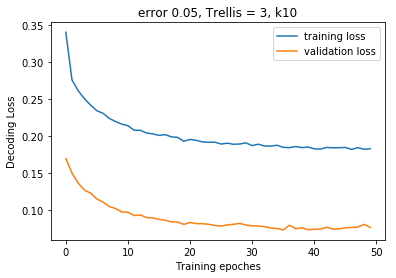

test accuracy: 0.972075

############## Example 0 ##############
Expected:
 [1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 1 1 1]
Actual:
 [1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 1 1 1]
Accuracy: 1.0

############## Example 1 ##############
Expected:
 [0 0 1 1 1 0 0 1 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1]
Actual:
 [0 0 1 1 1 0 0 1 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1]
Accuracy: 1.0


In [217]:
model, history = train_and_plot('../data/dataset_04/data/dataset_n25000_k10_e0.05.pkl',
               batch_size=128, epochs=50, verbose=0, plot=True, plot_title='error 0.05, Trellis = 3, k10',
               show_prediction_N=2, show_test_accuracy=True)

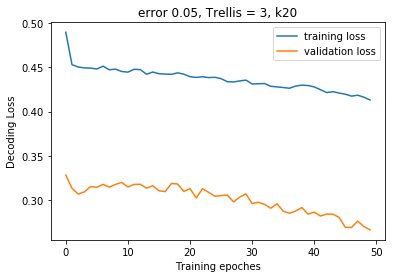

test accuracy: 0.9226681818181818

############## Example 0 ##############
Expected:
 [0 0 0 0 1 1 0 1 1 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0 0 0
 1 0 0 0 1 1 1]
Actual:
 [0 0 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0 0 0
 1 0 1 0 1 1 1]
Accuracy: 0.9545454545454546

############## Example 1 ##############
Expected:
 [1 1 0 1 1 1 0 0 1 1 1 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1
 1 0 1 1 1 0 0]
Actual:
 [1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 1 1 0 0 0 1 0 0 1 1 0 1 1 0 1 0 1 1 1 0 0 1
 1 0 1 1 1 0 0]
Accuracy: 0.9090909090909091


In [218]:
model, history = train_and_plot('../data/dataset_04/data/dataset_n25000_k20_e0.05.pkl',
               batch_size=128, epochs=50, verbose=0, plot=True, plot_title='error 0.05, Trellis = 3, k20',
               show_prediction_N=2, show_test_accuracy=True)

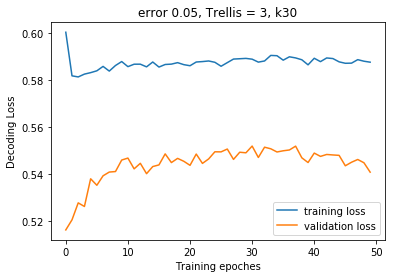

test accuracy: 0.6485375

############## Example 0 ##############
Expected:
 [1 1 1 0 0 1 0 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1
 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 1 1 1]
Actual:
 [1 1 1 0 0 1 0 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1
 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 1 1]
Accuracy: 0.671875

############## Example 1 ##############
Expected:
 [1 1 1 0 0 1 0 1 0 1 0 1 1 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0 1 1 1 0 1
 0 1 1 0 0 0 0 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 0]
Actual:
 [1 1 1 0 0 1 0 1 0 1 0 1 0 0 1 1 1 1 0 1 1 1 1 0 0 0 1 1 0 0 0 0 1 0 1 1 1
 1 1 0 1 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0]
Accuracy: 0.734375


In [219]:
model, history = train_and_plot('../data/dataset_04/data/dataset_n25000_k30_e0.05.pkl',
               batch_size=128, epochs=50, verbose=0, plot=True, plot_title='error 0.05, Trellis = 3, k30',
               show_prediction_N=2, show_test_accuracy=True)

In [221]:
data = pickle.load(open('../data/dataset_04/data/dataset_n25000_k10_e0.05.pkl', 'rb'))

In [316]:
encoded_seqs = np.array(data["encoded_seqs"])
noisy_seq = np.array(data["noisy_seqs"])

encoded_seqs = utils.np_utils.to_categorical(encoded_seqs).reshape((-1, 48))
# noisy_seq = utils.np_utils.to_categorical(noisy_seq)

In [317]:
print(encoded_seqs.shape, noisy_seq.shape)

(25000, 48) (25000, 24)


In [320]:
X_train, X_test, y_train, y_test = train_test_split(noisy_seq, encoded_seqs, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [321]:
X = tf.placeholder(dtype=tf.float32, shape=(None, 24), name="input")
Y = tf.placeholder(dtype=tf.float32, shape=(None, 48), name="output")

W1 = tf.Variable(tf.truncated_normal(shape=(24, 240), stddev=0.1))
b1 = tf.Variable(tf.constant(0.1, shape=(1, 240)))
layer1 = tf.nn.relu(tf.add(tf.matmul(X, W1), b1))

W2 = tf.Variable(tf.truncated_normal(shape=(240, 240), stddev=0.1))
b2 = tf.Variable(tf.constant(0.1, shape=(1, 240)))
layer2 = tf.nn.relu(tf.add(tf.matmul(layer1, W2), b2))

W_out = tf.Variable(tf.truncated_normal(shape=(240, 48), stddev=0.1))
b_out = tf.Variable(tf.constant(0.1, shape=(1, 48)))
logits = tf.add(tf.matmul(layer2, W_out), b_out)

In [326]:
entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = Y)
loss = tf.reduce_mean(entropy)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)

In [327]:
Y_pred = tf.nn.sigmoid(logits)
# y_pred_cls = tf.argmax(Y_pred, 1)
# y_cls = tf.argmax(Y, 1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(Y_pred, Y), tf.float32))

In [329]:
batch_size = 128
epochs = 25
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

n_batches = 64
for i in range(epochs):
    total_loss = 0
    for batch in range(n_batches):
        X_batch, y_batch = X_train[batch*batch_size:(batch+1)*batch_size], y_train[batch*batch_size:(batch+1)*batch_size]
        o, l = sess.run([optimizer, loss], feed_dict={X: X_batch, Y: y_batch})
        total_loss += l
    print("Epoch {0}: {1}".format(i, total_loss))
#     if i % 5 == 0 and i!= 0:
#         X_val, y_val = MNIST.validation.next_batch(MNIST.validation.num_examples)
#         val_accuracy = sess.run(accuracy, feed_dict={X: X_val, Y: y_val})
#         print("\tVal Accuracy {0}".format(val_accuracy))


Epoch 0: 45.36165368556976
Epoch 1: 44.98509842157364
Epoch 2: 44.67823678255081
Epoch 3: 44.41872924566269
Epoch 4: 44.192671954631805
Epoch 5: 43.99053406715393
Epoch 6: 43.80598157644272
Epoch 7: 43.63467633724213
Epoch 8: 43.47353678941727
Epoch 9: 43.320096135139465
Epoch 10: 43.17249912023544
Epoch 11: 43.02961724996567
Epoch 12: 42.890472173690796
Epoch 13: 42.754239201545715
Epoch 14: 42.62020766735077
Epoch 15: 42.48776262998581
Epoch 16: 42.356534361839294
Epoch 17: 42.22611045837402
Epoch 18: 42.09607398509979
Epoch 19: 41.96615767478943
Epoch 20: 41.83610689640045
Epoch 21: 41.705664455890656
Epoch 22: 41.57469880580902
Epoch 23: 41.4431174993515
Epoch 24: 41.3107892870903


In [332]:
sess.run([Y_pred], feed_dict={X: X_test[:2]})

[array([[0.5232242 , 0.5543356 , 0.5320701 , 0.31570813, 0.42081505,
         0.5593506 , 0.46936187, 0.52741706, 0.4944733 , 0.4594614 ,
         0.42250922, 0.59905005, 0.44590405, 0.602473  , 0.4704748 ,
         0.5045741 , 0.5167851 , 0.47804374, 0.55793536, 0.43694672,
         0.3750135 , 0.6036988 , 0.5115897 , 0.56087554, 0.51133096,
         0.43769965, 0.61609703, 0.3748115 , 0.45723042, 0.55984044,
         0.5401185 , 0.53626984, 0.46290985, 0.53718305, 0.56346077,
         0.45057485, 0.47734854, 0.5123727 , 0.5056353 , 0.46237403,
         0.5641439 , 0.5446276 , 0.44143602, 0.4262096 , 0.6087141 ,
         0.4802066 , 0.5263111 , 0.3724083 ],
        [0.5475989 , 0.48014063, 0.5129976 , 0.5254203 , 0.54981995,
         0.4632936 , 0.38470677, 0.5189415 , 0.5080466 , 0.4531786 ,
         0.5453861 , 0.41725   , 0.51779217, 0.43389374, 0.41892946,
         0.5507796 , 0.53479457, 0.4852404 , 0.4113132 , 0.63643175,
         0.4776348 , 0.4400379 , 0.4817493 , 0.48309374, 